# Data collection and preprocessing

We will run the preprocessing step with a small fraction of data. Test with the full dataset will be illustrated during the live demo on the cluster. 

## File descriptions

{0,1,2,3,4}.zip - are all HTML files. Files listed in train_v2.csv are training files:

file - the raw file name
labels: 0 - organic content; 1 - sponsored content

Following is the avro schema (contents of the avsc file) for the labels dataset:

```bash
{"namespace": "html.avro",		
	 "type": "record",	
	 "name": "Label",	
	 "fields": [	
	     {"name": "id", "type": "string"},	
	     {"name": "label", "type": "double"}	
	 ]	
	}	
```

Labels dataset needs tno preprocessing.

The corresponding documents (HTML web pages) are in the zip files:  

```bash
0,1,2,3,4.zip
```

And will have a following structure after preprocessing:

```bash
{"namespace": "html.avro",
 "type": "record",
 "name": "Html",
 "fields": [
     {"name": "id", "type": "string"},
     {"name": "images",  "type": {"type":"array", "items":"string"}},
     {"name": "links", "type": {"type":"array", "items":"string"}},
     {"name": "text", "type": "string"},
     {"name": "title", "type": {"type":"array", "items":"string"}}
 ]
}
```

## Web scraping

The term "scraping" refers to getting unstructured data and turning it into something usable in the analysis (or making it structured or semi-structured data). The tools available through Python are mature and easy to use. In our case the source data comes in HTML form. Typically we would use urllib to download pages on the web, but they are already downloaded for us here.

### The basic workflow is:

Find the data you want on the web *(again, in our case it is provided to us)*.

Inspect the page you are dealing with, to figure out how to zoom-in towards the content you want. This will involve some combiation of looking at the source code of the page (especially if it is simple), and
figuring out the structure of the HTML parse tree. This step is much easier with a something like *Chrome Developer Tools*.

Write code to get out what you want:
If the page is very simple, treat it as a bunch of text => string manipulation / regular expressions in Python.
If the page is more complicated (and/or written in good style), we want to use the HTML parse tree => BeautifulSoup in Python.

### CSS selectors

For most of the real world HTML documents, relular experession will not work well, as one has to use a lot of nested finds for specific classes/tags. It's so common that there is a special convenience language for such traversals: CSS selectors. BeautifulSoup supports a form of CSS selectors, and this will let us write the above in a more concise and expressive way:

Some basic building examples of selectors are:
1. 'mytag' picks out all tags of type mytag.
1. '#myid' picks out all tags whose id is equal to myid
1. '.myclass' picks out all tags whose class is equal to myclass
1. 'mytag#myid' will pick all tags of type mytag and id equal to myid (analgously for 'mytag.myclass')

If 'selector1' and 'selector2' are two selectors, then there is another selector 'selector1 selector2'. It picks out all tags satisfying selector2 that are descendents of something satisfying selector1, i.e., it's like our nested find.

## Example with our data

First, make sure that your notebook is running the Python from your Anaconda environment:

In [1]:
import sys
sys.version

'2.7.11 |Continuum Analytics, Inc.| (default, Dec  6 2015, 18:57:58) \n[GCC 4.2.1 (Apple Inc. build 5577)]'

In [1]:
from bs4 import BeautifulSoup
document = open("../preprocess/data/1118089_raw_html.txt","r").read()
soup = BeautifulSoup(document)
print soup.prettify()

/Users/alexeys/anaconda/envs/meetup_env/lib/python2.7/site-packages/bs4/__init__.py:166: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("html.parser"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

To get rid of this warning, change this:

 BeautifulSoup([your markup])

to this:

 BeautifulSoup([your markup], "html.parser")

  markup_type=markup_type))


# Find specific tags, classes

In [6]:
elements = soup.find_all('p', attrs={'class':'site-title'})
print elements

[<p class="site-title" itemprop="headline">\n<a href="http://www.almostsupermom.com/">\n        Almost Supermom\n       </a>\n</p>]


The parser we are going to use to extract text from our HTML pages consists of 2 find statements: one that looks for div tags of class "text" and the other one, more relaxed, that looks for all tags p:

In [9]:
def parse_text(soup):
    """ parameters:
            - soup: beautifulSoup4 parsed html page
        out:
            - textdata: a list of parsed text output by looping over html paragraph tags
        note:
            - could soup.get_text() instead but the output is more noisy """
    textdata = ['']

    #this is more strict 
    for tag in soup.find_all("div", {"class":"text"}):
        try:
           textdata.append(tag.text.encode('ascii','ignore').strip())
        except Exception:
           continue
 
    #more relaxed
    for text in soup.find_all('p'):
        try:
            textdata.append(text.text.encode('ascii','ignore').strip())
        except Exception:
            continue

    return textdata

In [45]:
parse_text(soup)

['',
 'Almost Supermom',
 'Able to Leap Piles of Laundry in a Single Bound',
 'July 13, 2015\n         \n         by\n         \n\n\n            Jordyn\n           \n\n\n\n\n           Leave a Comment',
 'Necessity is the mother of invention, so is the case with this scrumptious\n         \n          gluten free greek flatbread.',
 'It is so hot here in Atlanta. We are practically melting in the oppressive, sticky heat that the south is known for. Its the kind of heat that makes you want to sit on the couch and do nothing until the sun goes down. Turning on the oven is a repulsive thought as it will contribute to the overwhelming heat, so we nourish ourselves with salads and cold sandwiches in attempt to avoid turning into a puddle.',
 'The problem with salads and sandwiches is they can get boring. Really boring. In attempt to shake things up but stay cool, Ive been experimenting with different recipes that taste delicious, but require no cooking , at least not in the heat of the day.'

## Cleaning step

As you can see, the text we have extracted contains a lot of spurios white spaces and non-alphanumeric characters. Also, it comes as a list of strings. We are going to concatenate it all in 1 long string, remove those characters, and substitute multiple white spaces with just a single one:  

In [56]:
import re
def clean_text(text_as_list):
    text_as_string = " ".join(text_as_list)
    text_as_string = re.sub('\s+',' ',text_as_string)
    text_as_string = text_as_string.encode("utf8").translate(None,'=@&$/%?<>,[]{}()*.0123456789:;-\'"_').lower()

    return text_as_string

In [59]:
textdata = filter(None,parse_text(soup))
print clean_text(textdata)

almost supermom able to leap piles of laundry in a single bound july   by jordyn leave a comment necessity is the mother of invention so is the case with this scrumptious gluten free greek flatbread it is so hot here in atlanta we are practically melting in the oppressive sticky heat that the south is known for its the kind of heat that makes you want to sit on the couch and do nothing until the sun goes down turning on the oven is a repulsive thought as it will contribute to the overwhelming heat so we nourish ourselves with salads and cold sandwiches in attempt to avoid turning into a puddle the problem with salads and sandwiches is they can get boring really boring in attempt to shake things up but stay cool ive been experimenting with different recipes that taste delicious but require no cooking  at least not in the heat of the day one of the recipes that i created is this gluten free greek flatbread i can make the crust the night before when it isnt so hot and then throw the toppi

We skip the preprocessing step for the sake of saving time. You are encouraged to complete this step offline to obtain the JSON files.

## Converting JSON to Avro

Once the JSON files are obtained, use avro-tools.jar

```bash
java -jar avro-tools-1.7.7.jar fromjson --schema-file labels.avsc labels.json > labels.avro
java -jar avro-tools-1.7.7.jar fromjson --schema-file html.avsc html.json > html.avro
```

# Loading and exploring preprocessed data 

Download the preprocessed samples from Dropbox (using, for instance, wget):

labels: https://www.dropbox.com/s/lhi8kbgtharwn2x/labels.avro?dl=0
data: https://www.dropbox.com/s/5f1zy74o4igxsgd/html.avro?dl=0

Then, place those avro files to data folder:

```bash
mkdir classification/data
mv labels.avro html.avro classification/data
```

## Databricks spark-avro

Apache Avro is a data serialization system. We have added the dependency on spark-avro to link against the Databricks spark-avro library in the pom file.


In [60]:
print "Ingest data..."

train_label_df = sqlContext.read.format('com.databricks.spark.avro').load("./data/labels.avro")
input_df = sqlContext.read.format('com.databricks.spark.avro').load("./data/html.avro")
input_df.printSchema()
train_label_df.printSchema()
input_df.select("id","text").show()

Ingest data...
root
 |-- id: string (nullable = false)
 |-- images: array (nullable = false)
 |    |-- element: string (containsNull = false)
 |-- links: array (nullable = false)
 |    |-- element: string (containsNull = false)
 |-- text: string (nullable = false)
 |-- title: array (nullable = false)
 |    |-- element: string (containsNull = false)

root
 |-- id: string (nullable = false)
 |-- label: double (nullable = false)

+-------+--------------------+
|     id|                text|
+-------+--------------------+
|1309896|insolite art et a...|
|1309926|israeli missile n...|
|1309968|the page you are ...|
|1310010|advertisement #bd...|
|1310016|make more money !...|
|1310058| view comments lo...|
|1310064|posted in windows...|
|1310106|voor veel mensen ...|
|1310178|whats holding you...|
|1310214|get the best free...|
|1310226|v e n m s u l t a...|
|1310256|monthly mixes for...|
|1310346|youre helping us ...|
|1310352|                    |
|1310382|visitscotland use...|
|1310448|sh

In [62]:
#good example
input_df.select("id","text").where(input_df.id == 1310214).collect()

[Row(id=u'1310214', text=u'get the best free newsletter money can buy source wikipediaorg source tsunemi kubodera of the national science museum of japanap source wikipediaorg source wikipediaorg source crchicagoweeblycom source wikipediaorg source wikipediaorg source thecatalinaislandercom source wikipediaorg source wikipediaorg source wikipediaorg source wikipediaorg source bodegaheadblogspotcom source wikipediaorg source joi source animalwildlifeblogspotcom step away from the pesticide no girls allowed! clueless or lack of compassion were totally geeking out over here put your mindbody connection to the test')]

In [63]:
#problematic example
input_df.select("id","text").where(input_df.id == 1310562).collect()

[Row(id=u'1310562', text=u't m l l g e n t r u e f o r h t t p w w w p i c t u r e s o f e n g l a n d c o m r c b l z n z o z v z m e t a n a m e m s s m a r t t a g s p r e v e n t p a r s i n g c o n t e n t t r u e m e t a n a m e a u t h o r c o n t e n t j a m e s w i l s o n l i n k r e l m e t a h r e f h t t p w w w p i c t u r e s o f e n g l a n d c o m l a b e l s x m l t y p e a p p l i c a t i o n r d f + x m l t i t l e i c r a l a b e l s l i n k r e l s t y l e s h e e t t y p e t e x t c s s m e d i a s c r e e n h r e f c s s s t y l e n e w c s s l i n k r e l s t y l e s h e e t t y p e t e x t c s s m e d i a p r i n t h r e f c s s p r i n t c s s l i n k r e l s t y l e s h e e t t y p e t e x t c s s m e d i a s c r e e n h r e f c s s t o o l t i p s t e r c s s l i n k r e l s t y l e s h e e t t y p e t e x t c s s m e d i a s c r e e n h r e f c s s t o o l t i p s t e r n o i r c s s l i n k r e l s t y l e s h e e t t y p e t e x t c s s m e d i a s c r e

# Prepare feature and label dataframe

So far, the features and labels were in 2 separate dataframes (the raw data came in without labels, and labels were associated with filenames). We are going to need to have both in one dataframe.

This is very easy to achieve via a foolowing join:

In [64]:
train_wlabels_df = input_df.join(train_label_df,"id")
train_wlabels_df.printSchema()

root
 |-- id: string (nullable = false)
 |-- images: array (nullable = false)
 |    |-- element: string (containsNull = false)
 |-- links: array (nullable = false)
 |    |-- element: string (containsNull = false)
 |-- text: string (nullable = false)
 |-- title: array (nullable = false)
 |    |-- element: string (containsNull = false)
 |-- label: double (nullable = false)



# Feature engineering

Most of our features are text. There are several common types of features and approaches that form the "starting point" for NLP and text-based data problems. Here are a few of the common ones:

> Bag of words

> TF/IDF

> n-grams

> Stemming / part of speech tagging / etc.

> Feature hashing

## Some useful Python tools are:

> http://scikit-learn.org/stable/modules/feature_extraction.html

> http://www.nltk.org/

> http://www.nltk.org/howto/wordnet.html


## Prepare text features

We are going to try using all of the above techqniues, but with **spark.ml**

### Extract tokens

Our first step is to tokenize data. The simple way to tokenize a string (sentence) in Python is using the split() method as: 

In [87]:
input_document = "fruit eat tasty pie leaf cook tree computer computers laptop tech technology ceo jobs ipad iphone announce announced mac company companies employee employees user software released"
tokens = input_document.split(" ")
print tokens

['fruit', 'eat', 'tasty', 'pie', 'leaf', 'cook', 'tree', 'computer', 'computers', 'laptop', 'tech', 'technology', 'ceo', 'jobs', 'ipad', 'iphone', 'announce', 'announced', 'mac', 'company', 'companies', 'employee', 'employees', 'user', 'software', 'released']


Spakr ML has 2 tokenizers: default Tokenizer and RegexTokenizer which allows to specify a custom pattern to tokenize on. The latter is more flexible, we are going to use it:

In [88]:
from pyspark.ml.feature import RegexTokenizer, Tokenizer

print "Prepare text features..."
#tokenizer = Tokenizer(inputCol="text", outputCol="words")
tokenizer = RegexTokenizer(inputCol="text", outputCol="words", pattern="\\W")
tokenized_df = tokenizer.transform(train_wlabels_df)
tokenized_df.select("words").show(5)

Prepare text features...
+--------------------+
|               words|
+--------------------+
|[insolite, art, e...|
|[israeli, missile...|
|[the, page, you, ...|
|[advertisement, b...|
|[make, more, mone...|
+--------------------+
only showing top 5 rows



In [89]:
tokenized_df.select("words").take(2)

[Row(words=[u'insolite', u'art', u'et', u'autres', u'cest', u'une', u'srie', u'de', u'clichs', u'tonnants', u'pris', u'par', u'rian', u'van', u'schalkwyk', u'dans', u'lesquels', u'un', u'lphant', u'retourne', u'un', u'hippopotame', u'avec', u'sa', u'trompe', u'alors', u'quil', u'djeunait', u'dans', u'le', u'restaurant', u'de', u'la', u'rserve', u'private', u'game', u'erindi', u'en', u'namibie', u'ce', u'mdecin', u'observait', u'un', u'troupeau', u'dune', u'vingtaine', u'dhippopotames', u'qui', u'mangeaient', u'en', u'contrebas', u'dans', u'un', u'troue', u'deau', u'la', u'saison', u'tant', u'sche', u'le', u'personnel', u'leur', u'avait', u'apport', u'un', u'peu', u'dherbe', u'pour', u'pallier', u'au', u'manque', u'de', u'nourriture', u'cest', u'alors', u'quun', u'lphant', u'a', u'surgit', u'de', u'la', u'brousse', u'pour', u'profiter', u'de', u'laubaine', u'il', u'a', u'commenc', u'manger', u'tranquillement', u'puis', u'est', u'devenu', u'plus', u'agit', u'la', u'prsence', u'des', u'hi

## N-grams

Instead of looking at just single words, it is also useful to look at n-grams: these are n-word long sequences of words (i.e., each of "farmer's market", "market share", and "farm share" is a 2-gram).
The exact same tokenization techniques apply.

In [90]:
from pyspark.ml.feature import NGram

print "Try ngrams instead, or in addition..."
ngram = NGram(n=2, inputCol="words", outputCol="ngrams")
ngram_df = ngram.transform(tokenized_df)
ngram_df.select("ngrams").show(5)

Try ngrams instead, or in addition...
+--------------------+
|              ngrams|
+--------------------+
|[insolite art, ar...|
|[israeli missile,...|
|[the page, page y...|
|[advertisement bd...|
|[make more, more ...|
+--------------------+
only showing top 5 rows



In [91]:
ngram_df.select("ngrams").take(2)

[Row(ngrams=[u'insolite art', u'art et', u'et autres', u'autres cest', u'cest une', u'une srie', u'srie de', u'de clichs', u'clichs tonnants', u'tonnants pris', u'pris par', u'par rian', u'rian van', u'van schalkwyk', u'schalkwyk dans', u'dans lesquels', u'lesquels un', u'un lphant', u'lphant retourne', u'retourne un', u'un hippopotame', u'hippopotame avec', u'avec sa', u'sa trompe', u'trompe alors', u'alors quil', u'quil djeunait', u'djeunait dans', u'dans le', u'le restaurant', u'restaurant de', u'de la', u'la rserve', u'rserve private', u'private game', u'game erindi', u'erindi en', u'en namibie', u'namibie ce', u'ce mdecin', u'mdecin observait', u'observait un', u'un troupeau', u'troupeau dune', u'dune vingtaine', u'vingtaine dhippopotames', u'dhippopotames qui', u'qui mangeaient', u'mangeaient en', u'en contrebas', u'contrebas dans', u'dans un', u'un troue', u'troue deau', u'deau la', u'la saison', u'saison tant', u'tant sche', u'sche le', u'le personnel', u'personnel leur', u'leu

## Remove stopwords

It's common to want to omit certain common words when doing these counts -- "a", "an", and "the" are common enough so that their counts do not tend to give us any hints as to the meaning of documents. Such words that we want to omit are called stop words (they don't stop anything, though).

Spark ML contains a standard list of such stop words for English. One can include any custom stopwords, if need be.

In [92]:
from pyspark.ml.feature import StopWordsRemover

print "Remove stopwords"
remover = StopWordsRemover(inputCol="words", outputCol="filtered")
filtered_df = remover.transform(tokenized_df)
#filtered_df.printSchema()
filtered_df.select("filtered").show(5)

Remove stopwords
+--------------------+
|            filtered|
+--------------------+
|[insolite, art, e...|
|[israeli, missile...|
|[page, trying, vi...|
|[advertisement, b...|
|[make, money, tod...|
+--------------------+
only showing top 5 rows



In [93]:
filtered_df.select("filtered").take(2)

[Row(filtered=[u'insolite', u'art', u'et', u'autres', u'cest', u'une', u'srie', u'clichs', u'tonnants', u'pris', u'par', u'rian', u'van', u'schalkwyk', u'dans', u'lesquels', u'lphant', u'retourne', u'hippopotame', u'avec', u'sa', u'trompe', u'alors', u'quil', u'djeunait', u'dans', u'le', u'restaurant', u'la', u'rserve', u'private', u'game', u'erindi', u'en', u'namibie', u'ce', u'mdecin', u'observait', u'troupeau', u'dune', u'vingtaine', u'dhippopotames', u'qui', u'mangeaient', u'en', u'contrebas', u'dans', u'troue', u'deau', u'la', u'saison', u'tant', u'sche', u'le', u'personnel', u'leur', u'avait', u'apport', u'peu', u'dherbe', u'pour', u'pallier', u'au', u'manque', u'nourriture', u'cest', u'alors', u'quun', u'lphant', u'surgit', u'la', u'brousse', u'pour', u'profiter', u'laubaine', u'il', u'commenc', u'manger', u'tranquillement', u'puis', u'est', u'devenu', u'plus', u'agit', u'la', u'prsence', u'des', u'hippopotames', u'alors', u'quun', u'petit', u'passait', u'proximit', u'une', u'ma

## Feature hashing, TF-IDF


### Feature hashing

When doing "bag of words" type techniques on a *large* corpus and without an existing vocabulary, there is a simple trick that is often useful.  The issue (and solution) is as follows: 

 - The output is a feature vector, so that whenever we encounter a word we must look up which coordinate slot it is in.  A naive way would be to keep a list of all the words encoutered so far, and look up each word when it is encountered.  Whenever we encounter a new word, we see if we've already seen it before and if not -- assign it a new number.  This requires storing all the words that we have seen in memory, cannot be done in parallel (because we'd have to share the hash-table of seen words), etc.
 - A **hash function** takes as input something complicated (like a string) and spits out a number, with the desired property being that different inputs *usually* produce different outputs.  (This is how hash tables are implemented, as the name suggests.)
 - So -- rather than exactly looking up the coordinate of a given word, we can just use its hash value (modulo a big size that we choose).  This is fast and parallelizes easily.  (There are some downsides: You cannot tell, after the fact, what word each of your feature actually corresponds to!)
 
 
### TF-IDF weighting 

With single word vocabularies, we can probably do an okay job of coming up with a reasonable (if short) list of words that distinguish between the two documents.  With n-grams, even for $n=2$, it is better to let a computer help us.  

We would like to find words that are common in one document, not not common in all of them.  This is the goal of the __td-idf weighting__.  A precise definition is:

  1. If $d$ denotes a document and $t$ denotes a term, then the _raw term frequency_ $\mathrm{tf}^{raw}(t,d)$ is
  $$ \mathrm{tf}^{raw}(t,d) = \text{the number of times the term $t$ occurs in the document $d$} $$
  The vector of all term frequencies can optionally be _normalized_ either by dividing by the maximum of ny single word's occurance count ($L^1$) or by the Euclidean length of the vector of word occurance counts ($L^2$).  Scikit-learn by defaults does this second one:
  $$ \mathrm{tf}(t,d) = \mathrm{tf}^{L^2}(t,d) = \frac{\mathrm{tf}^{raw}(t,d)}{\sqrt{\sum_t \mathrm{tf}^{raw}(t,d)^2}} $$
  2. If $$ D = \left\{ d : d \in D \right\} $$ is the set of possible documents, then  the _inverse document frequency_ is
  $$ \mathrm{idf}^{naive}(t,D) = \log \frac{\# D}{\# \{d \in D : t \in d\}} \\
  = \log \frac{\text{count of all documents}}{\text{count of those documents containing the term $t$}} $$
  with a common variant being
  $$ \mathrm{idf}(t, D) = \log \frac{\# D}{1 + \# \{d \in D : t \in d\}} \\
   = \log \frac{\text{count of all documents}}{1 + \text{count of those documents containing the term $t$}} $$
  (This second one is the default in scikit-learn. Without this tweak we would omit the $1+$ in the denominator and have to worry about dividing by zero if $t$ is not found in any documents.)
  3. Finally, the weight that we assign to the term $t$ appearing in document $d$ and depending on the corpus of all documents $D$ is
  $$ \mathrm{tfidf}(t,d,D) = \mathrm{tf}(t,d) \mathrm{idf}(t,D) $$
  

In [94]:
from pyspark.ml.feature import HashingTF, IDF

#Hashing
hashingTF = HashingTF(inputCol="filtered", outputCol="rawFeatures", numFeatures=20)
featurized_df = hashingTF.transform(filtered_df)

idf = IDF(inputCol="rawFeatures", outputCol="features")
idfModel = idf.fit(featurized_df)
rescaled_df = idfModel.transform(featurized_df)
rescaled_df.select("features").show(5)

+--------------------+
|            features|
+--------------------+
|(20,[0,1,2,3,4,5,...|
|(20,[0,1,2,3,4,5,...|
|(20,[3,19],[0.495...|
|(20,[0,1,2,3,4,5,...|
|(20,[1,2,4,5,6,7,...|
+--------------------+
only showing top 5 rows



It is very common in practice to have sparse training data. Spark ML supports reading training examples stored in LIBSVM format. It is a text format in which each line represents a labeled sparse feature vector using the following format:

label index1:value1 index2:value2 ...

It has a type SparseVector.

In [95]:
rescaled_df.select("features").take(1)

[Row(features=SparseVector(20, {0: 1.0513, 1: 2.5628, 2: 4.3698, 3: 2.2317, 4: 1.8889, 5: 8.7509, 6: 1.9458, 7: 3.744, 8: 2.4062, 9: 2.944, 10: 3.1251, 11: 3.0351, 12: 0.9603, 13: 2.1758, 14: 2.5186, 15: 3.2417, 16: 2.6389, 17: 2.5166, 18: 1.6455, 19: 1.8112}))]

## Stemming

Let us look at the two words: "computer" and "computers".  It would have been useful to identify them as one word.

This is not limited to just trailing "s" characters: e.g., the words "carry", "carries", "carrying", and "carried" all carry -- roughly -- the same meaning.  The process of replacing them by a common root, or **stem**, is called stemming -- the stem will not, in general, be a full word itself.

There's a related process called **lemmatization**: The analog of the "stem" here _is_ an actual word.  

# Building a model

## Supervised Machine Learning

For this and all other machine-learning setups, 

$$X = \{X_{ji}\}$$

is an $n \times p$ matrix of features and 

$$y_j$$

is an $n$-vector of labels.  In all **supervised** learning problems, we are trying to build a **model** $f$ (predictive relationship) that maps the feature rows $\{X_{j \cdot}\}$ to each label $y_j$ so that 

$$f(X_{j \cdot}) \approx y_j.$$

With this predictive model, future we will be able to predict the label associated with new feature row $X'_{j \cdot}$ via $f(X'_{j \cdot})$.  That's it.

A few key concepts:
1. Within Supervised machine learning, there are roughly two broad classes of problems, **Regression** and **Classification**.  Regression is when the values of $y$ are continuous and real-valued.  Classification is when $y$ takes on a discrete discrete number of possible values.
1. What does it mean for the prediction to be accurate?  That depends on what **metric** we use, which is at the discretion of the modeller.  Obviously, some metrics make sense for regression, and others for classification.  And some make sense for 


## Decision Trees

A decision tree is a binary tree.  At each of the internal nodes, it chooses a feature $i$ and a threshold $t$.  Each leaf has a value.  Evaluation of the model is just traversal of the tree from the root. At each node, for example $j$, we go down the left branch if $X_{ji} \le t$ and the right branch otherwise.  The value of the model $f(X_{ji})$ is the value at the value at the terminating leaf of this traveral. 

Each internal node has a decision criterion and each leaf has the breakdown of label classes left at this leaf of the tree. For a geometric picture of a decision tree, take a look at this [blog post](https://shapeofdata.wordpress.com/2013/07/02/decision-trees/).


### Decision Tree Training Algorithm and Tuning Parameters

The algorithm to construct a Decision Tree recursively builds a tree structure.  At each node, it finds the split (the feature and threshold level) that maximize the improvement in a criteria (the decrease in the gini index, or an entropy gain).  This algorithm is controlled by the following major parameters:

<table>
	<tr>
    <th>Feature</th>
    <th>Value</th>
	</tr>

	<tr>
    <td>`setImpurity`</td>
    <td>Type of impurity: Gini, entropy gain</td>
	</tr>

	<tr>
    <td>`setMaxDepth`</td>
    <td>The maximum depth of tree from the root</td>
	</tr>

	<tr>
    <td>`setMinInfoGain`</td>
    <td></td>
	</tr>

	<tr>
    <td>`setMaxBins`</td>
    <td></td>
	</tr>
</table>


Increasing `max_features` and `max_depth` and decreasing `min_samples_split` and `min_samples_leaf` tend to build more complex models (increase Variance and reduce Bias).


## Random Forests

A random forest is just an ensemble of decision trees.  The predicted value is just the average of the trees (for both regression and classification problems - for classification problems, it is the probabilities that are averaged).  You can adjust the number of trees in the forest.  If each tree is trained on the same subset of data, why aren't they identical?  Two reasons:
1. **Subsampling** or **Bootstraping**: each tree is actually trained on a random selected (with replacement) subset of initial training sample
1. **Maximum Features**: the optimal split comes from a randomly selected subset of the features.  

In addition to the above parameters which are used when optimising the decision tree learning, following parameters apply to the random forests:

<table>
	<tr>
    <th>Feature</th>
    <th>Value</th>
	</tr>

	<tr>
    <td>`setSubsamplingRate`</td>
    <td>Each tree is actually trained on a random selected (with replacement) subset of initial training sample.</td>
	</tr>
    
    <tr>
    <td>`setFeatureSubsetStrategy`</td>
    <td>The optimal split comes from a randomly selected subset of the features.</td>
	</tr>
</table>


The variance between different trees tends to cancel each other while the biases reinforce each other.  That is, becasue the trees are different, they tend to overfit in different ways but when they underfit, they underfit the same way.  So you want to use higher variance, lower bias parameters than you would with a decision tree.

In [96]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import StringIndexer, VectorIndexer

# Index labels, adding metadata to the label column.
# Fit on whole dataset to include all labels in index.
labelIndexer = StringIndexer(inputCol="label", outputCol="indexedLabel")
# Automatically identify categorical features, and index them.
# Set maxCategories so features with > 4 distinct values are treated as continuous.
featureIndexer = VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=2)

rf = RandomForestClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures",numTrees=10,impurity="gini",maxDepth=4,maxBins=32)

# Putting it all into a machine learning pipeline

In machine learning, it is common to run a sequence of algorithms to process and learn from data. E.g., a simple text document processing workflow might include several stages:

<img src="http://spark.apache.org/docs/latest/img/ml-PipelineModel.png">


## How it works
A Pipeline is specified as a sequence of stages, and each stage is either a Transformer or an Estimator (see slides for the meaning). These stages are run in order, and the input DataFrame is transformed as it passes through each stage. For Transformer stages, the transform() method is called on the DataFrame. For Estimator stages, the fit() method is called to produce a Transformer (which becomes part of the PipelineModel, or fitted Pipeline), and that Transformer’s transform() method is called on the DataFrame.

In [97]:
from pyspark.ml import Pipeline

pipeline = Pipeline(stages=[tokenizer, remover, hashingTF, idf, labelIndexer, featureIndexer, rf])

# Overfitting, regularization

Overfitting occurs when a statistical model describes random error or noise instead of the underlying relationship. Overfitting generally occurs when a model is excessively complex, such as having too many parameters relative to the number of observations. A model that has been overfit will generally have poor predictive performance, as it can exaggerate minor fluctuations in the data (Wikipedia definition).

In the following artificial example let us generate data and use a decision tree to illustrate a bias-variance tradeoff.  Let's start by generaing and plotting some data

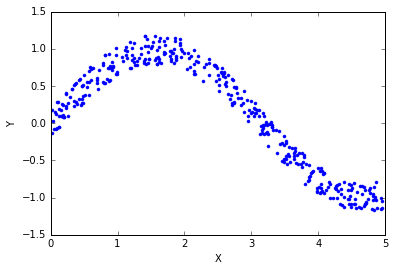

In [3]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

# Create a random dataset
rng = np.random.RandomState(42)
N_points = 400
X = np.sort(5 * rng.rand(N_points, 1), axis=0)
y = np.sin(X).ravel() + .4 * (0.5 - rng.rand(N_points))

plt.plot(X, y, 'b.')
plt.xlabel('Data')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

## Decision Trees

In case of the decision trees, the complexity of the model is detemined by the depth of the tree.

For this example, I will use a simple binary decision tree from scikit-learn, train it on the data we have just generated, and visualize the model:

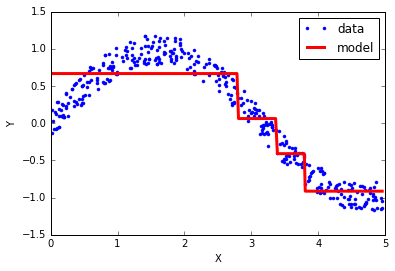

In [4]:
# Train a 2 level decision tree

from sklearn import tree
max_depth = 2
clf = tree.DecisionTreeRegressor(max_depth=max_depth)
clf.fit(X, y)
plt.plot(X, y, '.', label='data')
line = plt.plot(X, clf.predict(X), '-r', label='model')
plt.setp(line, linewidth=3.)
plt.xlabel('X')
plt.ylabel('Y')
plt.legend(loc='upper right')
plt.show()

## Measuring Error Computationally - In-Sample Error

Naively, you might think that we could just measure the error of the model and choose the model with the best error.  For example, let's define the error as the mean squared error (MSE).  Let's try that below

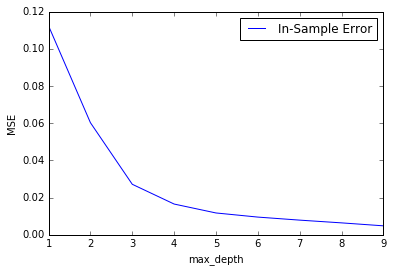

In [5]:
from sklearn import metrics

max_depths = range(1, 10)
in_sample_errors = []
for max_depth in max_depths:
    clf = tree.DecisionTreeRegressor(max_depth=max_depth).fit(X, y)
    y_pred = clf.predict(X)
    in_sample_errors.append(metrics.mean_squared_error(y, y_pred))
    
plt.plot(max_depths, in_sample_errors, label='In-Sample Error')
plt.xlabel('max_depth')
plt.ylabel('MSE')
plt.legend(loc='upper right')

We can see that the error is decreasing with the depth of the tree.  Our visual inspection told us models with `max_depth = 8` or greater completely overfits.  It turns out that the *In-Sample Error* that we calcualted above will always decrease with the complexity of the model (in this case, the depth of the tree).  We can see from above that this leads us to *overfit* the data.  In order to test how well our model *generalizes*, we need to see how it performs out new data.

## Measuring Error Computationally: Out-of-Sample Error

One way to do this is to (randomly) split the data into training and test sets.  We train on the training set and test the resulting model on the test set.  Since the trained model never saw the test data, we can evaluate the performance on the test data.

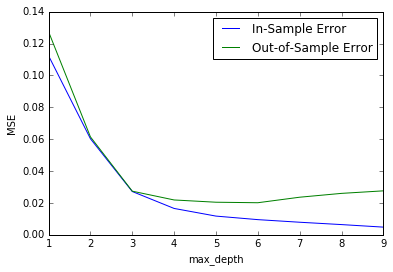

In [6]:
from sklearn import cross_validation
from sklearn import metrics

X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.2, random_state=42)

test_errors = []
for max_depth in max_depths:
    clf = tree.DecisionTreeRegressor(max_depth=max_depth).fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    test_errors.append(metrics.mean_squared_error(y_test, y_pred))

plt.plot(max_depths, in_sample_errors, label='In-Sample Error')
plt.plot(max_depths, test_errors, label='Out-of-Sample Error')
plt.xlabel('max_depth')
plt.ylabel('MSE')
plt.legend(loc='upper right')

## Variance-Bias Tradeoff

This is the picture we were looking for:  the *In-Sample Error* is always decreasing but the out *Out-of-Sample Error* initially decreases with model complexity (higher `max_depth`) but ultimately increases again.  The *Out-of-Sample Error* is the metric to look at when evaluating overfitting.

It turns out that this is an illustration of a very general problem in machine-learning called **Bias-Variance tradeoff** (the concept is so general that it even has a [Wikipedia article](https://en.wikipedia.org/wiki/Bias%E2%80%93variance_dilemma). The tradeoff tells us that we can decompose our *Out-of-Sample Error* into

$$ \mbox{Out-of-Sample Error} = \mbox{Bias} + \mbox{Variance}. $$

The *Bias* corresponds to how far off we expect the model to deviate from reality (i.e. the model's bias) because of parametric assumptions (e.g. we forced the model to be linear or to be a tree of maximum depth 2).  It is given by the *In-Sample Error* of the above plot and always goes down with complexity.  High Bias models correspond to *underfitting*.

The *Variance* accounts for the fact that the model was only trained on a (noisy) subset of the data and that the idiosyncratic noise in the data is therefore likely to contribute some variance to the model.  The more complex we allow the model to be, the more likely we are to overfit by picking up more of this noise.  High variance modesl correspond to *overfitting*.

We can also think of bias as unmodelled data and variance as modelled noise.  As we increase the complexity of the model, we will necessarily model more of the data (reduce bais, reduce underfitting) but also start modelling noise (increase variance, increase overfitting).  Here's a helpful diagram of the decomposition.  Notice that at the optimal point, we have not yet learned on all our signal (still unmodelled data left) and we have picked up some noise and overfitting.

![Bias-Variance](./images/bias-variance.png) 


## Cross-Validation strategies

The strategy used above was a fairly elementary.  One could, for example, split the data into $k$ parts (called *folds*), train on $k-1$ of them and test the resulting model on the last one.  This is called *K-Fold Validation*.  There are many variations.  Here are just two:

- *Stratified K-Fold Validation*: restrict the folds to have the same percentage of y's as the full sample.
- *Leave-One-Out*: If $k=n$ K-Fold Validaiton.
- *Leave-$p$-Out*: You can probably guess ...



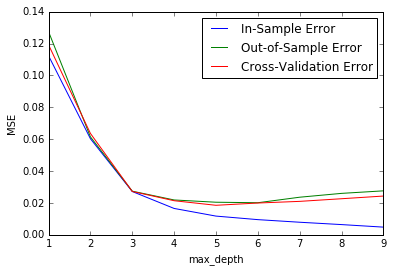

In [7]:
cv_test_errors = []
for max_depth in max_depths:
    clf = tree.DecisionTreeRegressor(max_depth=max_depth)
    
    # The K-fold Cross Validation algorithm has a bug (feature?) where it makes the folds consecutive elements.
    # Because the input data is presorted along X, we have to first shuffle the input data.  (Exercise: What happens if we don't?)
    indices = np.random.permutation(xrange(len(y)))
    X_random_order, y_random_order = X[indices], y[indices]
    
    # Note that cross_val_score performs K-fold Cross Validation but returns a score, which is the negative of the error.
    cv_test_error = -cross_validation.cross_val_score(clf, X_random_order, y_random_order, cv=5, scoring='mean_squared_error')
    cv_test_errors.append(cv_test_error.mean())

plt.plot(max_depths, in_sample_errors, label='In-Sample Error')
plt.plot(max_depths, test_errors, label='Out-of-Sample Error')
plt.plot(max_depths, cv_test_errors, label='Cross-Validation Error')
plt.xlabel('max_depth')
plt.ylabel('MSE')
plt.legend(loc='upper right')

# More on bootstraping and stratified sampling

In our example's data, we are dealing with a 2 class classification problem: possible labels are 0 or 1. Let us take a look at the fractions of these labels:  

In [ ]:
train_wlabels_df.where(train_wlabels_df.label == 1).count()/float(train_wlabels_df.count())*100.

In [ ]:
train_wlabels_df.where(train_wlabels_df.label == 0).count()/float(train_wlabels_df.count())*100

We can see that label 1 is underrepresented, comprisoing just about 10%.

Normally we need to use stratification (stratified sampling) or bootstrap sampling when working with such unbalanced data. In short, what these methods do is they look at the class labels on the training/cross validation stage, and try to prepare a sample which would have a distribution similar to what one could draw from the whole population. With bootstraping one can change the fractions of classes in the sample.


If you are working with RDDs of key-value pairs (pair RDDs), you can use stratified sampling methods like **sampleByKey** and **sampleByKeyExact**. For stratified sampling, the keys can be thought of as a label and the value as a specific attribute. The sampleByKey method will flip a coin to decide whether an observation will be sampled or not, therefore requires one pass over the data, and provides an expected sample size. sampleByKeyExact requires significant more resources than the per-stratum simple random sampling used in sampleByKey, but will provide the exact sampling size with 99.99% confidence. sampleByKeyExact is currently not supported in python.

The sampleByKey and sampleByKeyExact functions take **withReplacement** parameter. Posisson or Bernoulli sampling function is used depending on that flag:

```scala
    val samplingFunc = if (withReplacement) {
      StratifiedSamplingUtils.getPoissonSamplingFunction(self, fractions, false, seed)
    } else {
      StratifiedSamplingUtils.getBernoulliSamplingFunction(self, fractions, false, seed)
    }
```    
 
With DataFrames, only the sampleBy method is currently available, and a subset of rows of the initial dataframe is with a specific label is selected by sampling random uniform distribution.

For our exercises, we are just going to play with the fraction of the larger class and see an advnatage of downsampling it:

In [ ]:
#1 is under represented class
fractions = {1.0:1.0, 0.0:0.5}
stratified = train_wlabels_df.sampleBy("label", fractions, 36L)

train, cv = stratified.randomSplit([0.8, 0.2])

# Evaluating a model

## Metrics for Classificaton

There are a plethora of metrics for classification and they depend on whether the predictions are given in terms of the potential label classes or probabilities.

### Metrics for Class Predictions

Let's start with the simplest.

Recall this well-known table

|                     | Observation Positive     | Observation Negative    |
|---------------------|:------------------------:|:-----------------------:|
| Prediction Positive |     True Positive        | False Positive (Type I) |
| Prediction Negative | False Negative (Type II) |     True Negative       |

There are many summary statistics one can compute from this table:
1. The **Accuracy** gives the fraction labels correctly predicted (True Positives and True Negatives over everything).  
1. The **Hamming Loss** gives the fraction of labels incorrectly predicted.  It is 1 - Accuracy.
1. The **Precision** is true positives divided by all positive predictions 
1. The **Recall** is true positives divided by all positive observations.
1. There is also **F-beta** score which gives a weighted geometric average between the precision and recall (as a function of $\beta$) and the **F-1** score is the special case when $\beta = 1$.
1. The **Jaccard Similarity Coefficient** is the True positives divided by the sum of true positives, false negatives, and false positives.  

In [ ]:
from sklearn import metrics
# Accuracy and Hamming distnace:

y_obs  = [0, 0, 1, 1, 0, 1, 0, 1]
y_pred = [0, 0, 1, 1, 0, 0, 0, 1]

print "Accuracy:", metrics.accuracy_score(y_obs, y_pred)
print "Hamming Loss:", metrics.hamming_loss(y_obs, y_pred)
print "Precision:", metrics.precision_score(y_obs, y_pred)
print "Recall:", metrics.recall_score(y_obs, y_pred)
print "F1:", metrics.f1_score(y_obs, y_pred)
print "Jaccard:", metrics.jaccard_similarity_score(y_obs, y_pred)

## Single-valued Probabilistic Prediction Metrics

While a modeller can decide the appropriate threshold once given a precision-recall curve, it is hard to optimzie for and it doesn't necessarily make sense to optimize for "Precision at .6" (why not "Precision at .7"?).  We need a single-valued metric that is independent of threshold.  Fortunately, there are two common ones:

1. The **Area under the Curve** or **AUC** computes the area under the Precision Recall curve.
1. There is a **Receiver Operating Charateristic**, which is similar to the Precision-Recall curve.  The area under this curve is itself a metric called **ROC-AUC**.  The definition isn't hard, but it's beyond the scope of this course.  You can find out more [on Wikipedia](https://en.wikipedia.org/wiki/Receiver_operating_characteristic)
1. The **Log-Loss** or **Entropy** is another characteristic.  It is related to the notion of Entropy in Thermodynamics and Shannon-Entropy.  For a binary class problem where $y_j$ is either $0$ or $1$, it is given by

$$ - \sum_j \left[y_j \log(p_j) + (1-y_j) \log(1-p_j)\right] $$

In [ ]:
# AUC, ROC-AUC, Log-loss

# for entropy, we need the predictions and observations by-class
# e.g. two columns for a binomial prediction.
y_pred_full = np.vstack([y_pred, 1-y_pred]).T
y_obs_full = np.vstack([y_obs, 1-y_obs]).T

# You can compute AUC either via the AUC function by the average_precision_score
print "AUC by hand:", metrics.auc(recalls, precisions)
print "AUC:", metrics.average_precision_score(y_obs, y_pred)
print "ROC-AUC:", metrics.roc_auc_score(y_obs, y_pred)
print "Entropy:", metrics.log_loss(y_obs_full, y_pred_full)

### Metrics for Class Predictions
1. Precision gives what fraction of positive predictions we got right.  Recall tells us how many true positives we were able to find.


### Precision-Recall Tradeoff
1. Increasing $\underline p$ increases precision and decreases recall.  Here, we are assuming that the estimator is halfway decent.
1. A perfect estimator would be a horizontal line across the top of the graph.  If it were guessing at random, it would be a horizontal line at the global rate of positive examples (precision at recall = 1.).
1. Using $1-f$ will result in an estimator that is below the line of a random estimator (i.e. it is strictly worse than just guessing).
1. We want a high precision process when the cost of a false positive is high.  We want a high recall process when the cost of a false negative is high.
1. You want a high precision Spam Detector (better to read a few extra spam emails then that email telling you about your promotion).


### Single-valued Probabilistic Prediction Metrics
1.  If $p_{jk}$ is the probability that example $j$ will be in class $k$, then the entropy is
    $$ \sum_j \sum_{k: y_j = k}\log(p_{jk}) \,.$$
    Remember that $\sum_k p_{jk} = 1$.
1.  The average precision means precision integrated over recall.  If you draw out the picture, it is exactly the area under the precision recall curve.

# Binary and multiclass classification evaluators in spark ml

In Spark ML, we have two main classes for evaluators:

**BinaryClassificationEvaluator**: evaluator for binary classification, which expects two input columns: score and label.
It uses areaUnderROC (area under the receiver operating characteristic curve) and areaUnderPR (area under the precision-recall curve) metrics to evaluate a classifier. 

**MulticlassClassificationEvaluator**: evaluator for multi-class classification.
metricName options are f1, precision, recall

In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

#Note that the evaluator here is a BinaryClassificationEvaluator and its default metric
#is areaUnderROC.
#metricName options are: areaUnderROC|areaUnderPR)
metricName = "areaUnderPR"
ev = BinaryClassificationEvaluator(metricName=metricName)
#Alternative: user multiclass classification evaluator
#metricName options are f1, precision, recall
#ev = MulticlassClassificationEvaluator(metricName="f1")

# Fit the pipeline to training documents.
model = pipeline.fit(train)

print "Evaluate model on test instances and compute test error..."
prediction = model.transform(cv)
#prediction = labelConverter.transform(prediction)
prediction.select("label", "text", "probability", "prediction").show(5)

result = ev.evaluate(prediction)
print metricName,": ", result

cvErr = prediction.filter(prediction.label == prediction.prediction).count() / float(cv.count())
print 'CV Error = ' + str(cvErr)    

# Hyper parameter search

How can we further improve the perfromance? We can perfrom a hyper parameter search to make sure we get the most of our classifier.

We are going to use the CrossValidator to select from a grid of parameters. To help construct the parameter grid, we will use the ParamGridBuilder utility. At the moment of preparing this materials, only the Scala implementation was fully working, so we are going to switch to the Scala-based implementation till the rest of the night and follow it as a demo-only:
https://github.com/ASvyatkovskiy/MLmeetup2016/blob/master/classification/src/main/scala/ClassificationAdhoc.scala

Note that cross-validation over a grid of parameters is expensive. However, it is also a well-established method for choosing parameters which is more statistically sound than heuristic hand-tuning.

Here is what we are going to start with:


```scala
    var paramGrid = new ParamGridBuilder()
                    .addGrid(hashingTF.numFeatures, Array(10, 20, 100))
                    .addGrid(rf.numTrees, Array(3, 5, 10))
                    .build()
  
    //set estimator 
    var crossval = new CrossValidator().setEstimator(rf).
                              setEstimatorParamMaps(paramGrid).
                              setEvaluator(ev).
                              setNumFolds(3)
```

# Adding custom features to the model

So far we were dealing with text features only, and we were able to achieve 95% accuracy on the cross validation set.
As you know, the structure of our data is as follows:

```bash
{"namespace": "html.avro",
 "type": "record",
 "name": "Html",
 "fields": [
     {"name": "id", "type": "string"},
     {"name": "images",  "type": {"type":"array", "items":"string"}},
     {"name": "links", "type": {"type":"array", "items":"string"}},
     {"name": "text", "type": "string"},
     {"name": "title", "type": {"type":"array", "items":"string"}}
 ]
}
```

So we have the info about the page title, links, and images. The simpels adhoc features one can construct and test are the count features. Namely, the number of links on a page, number of images.

There is no built-in functionality in Spark ML which would allow to modify the **features** column of the dataframe by appending two more components to the SparseVector which is the underlying container there.

So a simple starting point can be this UDF:

```scala
  def appendFeature(sv: SparseVector, adhoc_feature1: Int, adhoc_feature2: Int) : Vector = {

      val inputValues = sv.values
      val inputIndices = sv.indices
      val inputValuesLength = inputValues.length
      val dim = sv.size

      var adhoc_features = Array(adhoc_feature1,adhoc_feature2)
      val addhoc_size = adhoc_features.length

      val outputValues = Array.ofDim[Double](inputValuesLength + addhoc_size)
      val outputIndices = Array.ofDim[Int](inputValuesLength + addhoc_size)

      System.arraycopy(inputValues, 0, outputValues, 0, inputValuesLength)
      System.arraycopy(inputIndices, 0, outputIndices, 0, inputValuesLength)

      for (i <- 1 to addhoc_size) {
        outputValues(inputValuesLength-1+i) = adhoc_features(i-1).toDouble
      }
      outputIndices(inputValuesLength) = dim

      Vectors.sparse(dim + addhoc_size, outputIndices, outputValues)

  }
```  

Which can be applied in Spark like this:

```scala
    def appendFeature_udf = udf(appendFeature _)
    var adhoc_df = rescaled_df.withColumn("features", appendFeature_udf(col("pre_features"),col("links_cnt"),col("images_cnt"))) 
```    

## Bag-of-words and image: starting points